In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
#globals
TOTAL_FEATURES = 7
BACK_CANDLES = 100
FUTURE_DAYS = 10

def create_stock_dictionary():
    dictionary = {}
    current_directory = os.getcwd()
    folder_name = 'S&P500Daily'
    folder_path = os.path.join(current_directory, folder_name)

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            name = file_name.split("_")[0]
            file_path = os.path.join(folder_path, file_name)
            dictionary[name] = pd.read_csv(file_path)
            
    return dictionary


In [5]:
import random
import copy
stock_data = create_stock_dictionary()
stock_data_copy = copy.deepcopy(stock_data)


In [3]:
#create sorted dictionary based on average 200 day closing price for training
stock_data_avg_price_dict = {}
for key in stock_data.keys():
    stock_data_avg_price_dict[key] = stock_data[key]['Close'].tail(200).mean()
stock_data_avg_price_dict = dict(sorted(stock_data_avg_price_dict.items(), key=lambda item: item[1]))

In [6]:
from sklearn.model_selection import train_test_split
import math
n_days = BACK_CANDLES
m_days = FUTURE_DAYS
stock_data_training = {}
stock_data_testing = {}
scalers = {}
#split data for training
for i in stock_data.keys():
    #add more features here
    stock_data[i].rename(columns = {'Datetime':'Date'}, inplace = True)
    
    #ADX
    adx_indicator = ta.adx(high=stock_data[i]['High'], low=stock_data[i]['Low'], close=stock_data[i]['Close'])
    stock_data[i]['ADX'] = adx_indicator['ADX_14']
    #MACD and Helper
    #MACD = ta.macd(stock_data[i]['Close'])
    #stock_data[i]['MACD_Helper'] = np.where(stock_data[i]['MACD'] < MACD['MACDs_12_26_9'], -1, 0)
    #stock_data[i]['MACD_Helper'] = np.where(stock_data[i]['MACD'] > MACD['MACDs_12_26_9'], 1, 0)
    
    #RSI and Helper
    stock_data[i]['RSI'] = ta.rsi(stock_data[i]['Close'])
    #stock_data[i]['RSI_Helper'] = np.where(stock_data[i]['RSI'] <= 30, -1, 0)
    #stock_data[i]['RSI_Helper'] = np.where(stock_data[i]['RSI'] >= 70, 1, 0)
        
    #Bollinger Bands and Helper
    bbands = ta.bbands(stock_data[i]['Close'])
    stock_data[i]['BBand'] = (bbands['BBU_5_2.0'] - bbands['BBL_5_2.0']) / stock_data[i]['Close']
    
    stock_data[i]["TargetNextClose"] = stock_data[i]["Adj Close"].shift(-1)
    stock_data[i].drop(['Close', 'Open', 'High', 'Low'], axis=1, inplace=True)
    
    #change scaling algorithm
    scaler = MinMaxScaler(feature_range=(0,1))
    column_names = stock_data[i].columns
    for k in range(1, stock_data[i].shape[1]):
        column_data = stock_data[i].iloc[:, k].values.reshape(-1, 1)
        stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
        if(column_names[k] == 'Adj Close'):
            scalers[i] = scaler
    stock_data_training[i], stock_data_testing[i] = train_test_split(stock_data[i], test_size=0.2, shuffle=False)

    testing_start_index = stock_data_testing[i].index[0]
    previous_indices = stock_data[i].iloc[max(0, testing_start_index - 100):testing_start_index].index

    stock_data_testing[i] = stock_data[i].loc[previous_indices.union(stock_data_testing[i].index)]

C:\Users\Rober\AppData\Local\Temp\ipykernel_26152\693937956.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00285561 0.00349338 0.00689549 ... 0.04162291 0.06491854 0.04268291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_26152\693937956.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.2379488  0.22599306 0.16416843 ... 0.01017807 0.02588406 0.01175861]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stock_data[i].iloc[:, k] = scaler.fit_transform(column_data)
C:\Users\Rober\AppData\Local\Temp\ipykernel_26152\693937956.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 

In [7]:
stock_data_testing['AAPL'].head(100)

,Date,Adj Close,Volume,ADX,RSI,BBand,TargetNextClose
2204,2022-03-16,0.784213,0.075136,0.395471,0.359943,0.270306,0.789697
2205,2022-03-17,0.789697,0.049514,0.388307,0.379362,0.308441,0.807587
2206,2022-03-18,0.807587,0.095502,0.366828,0.440520,0.391030,0.815041
2207,2022-03-21,0.815041,0.068905,0.339590,0.464871,0.298200,0.833356
2208,2022-03-22,0.833356,0.055195,0.307838,0.521802,0.268576,0.840757
...,...,...,...,...,...,...,...
2299,2022-08-02,0.787701,0.034431,0.212362,0.632631,0.187703,0.820334
2300,2022-08-03,0.820334,0.056131,0.238578,0.717956,0.235781,0.818628
2301,2022-08-04,0.818628,0.030174,0.264313,0.708347,0.194240,0.817399
2302,2022-08-05,0.817399,0.031349,0.279448,0.693823,0.203792,0.814836


In [8]:
#Correlation testing
stock_data_correlation_test = copy.deepcopy(stock_data_testing['AAPL'])
stock_data_correlation_test.drop(['Date'], axis=1, inplace=True)
stock_data_correlation_test.corr()

,Adj Close,Volume,ADX,RSI,BBand,TargetNextClose
Adj Close,1.000000,-0.471274,0.498368,0.370092,-0.463353,0.989012
Volume,-0.471274,1.000000,-0.349384,-0.292018,0.596665,-0.473312
ADX,0.498368,-0.349384,1.000000,0.345386,-0.317346,0.501492
RSI,0.370092,-0.292018,0.345386,1.000000,-0.310668,0.367027
BBand,-0.463353,0.596665,-0.317346,-0.310668,1.000000,-0.464328
TargetNextClose,0.989012,-0.473312,0.501492,0.367027,-0.464328,1.000000


In [9]:
#code that lets you select which stocks you want to train on, so you can use other stocks to train
vals = list(stock_data_avg_price_dict.keys())
training_vals = vals[200:222]
training_df_list = []
for key in stock_data_training.keys():
    for item in training_vals:
        if(key == item):
            training_df_list.append(stock_data_training[key])
            

stacked_stock_data = pd.concat(training_df_list, ignore_index=True, axis=0)
stacked_stock_data = stacked_stock_data.dropna()
stacked_stock_data


,Date,Adj Close,Volume,ADX,RSI,BBand,TargetNextClose
27,2013-07-24,0.007135,0.268121,0.547475,0.374510,0.090426,0.006419
28,2013-07-25,0.006419,0.241349,0.513348,0.357969,0.063886,0.006382
29,2013-07-26,0.006382,0.213874,0.490967,0.357057,0.039865,0.006118
30,2013-07-29,0.006118,0.165914,0.469205,0.350260,0.023812,0.007248
31,2013-07-30,0.007248,0.282320,0.439562,0.389339,0.025073,0.008358
...,...,...,...,...,...,...,...
45330,2022-03-09,0.201413,0.200333,0.264068,0.345260,0.271656,0.197062
45331,2022-03-10,0.197062,0.074122,0.281653,0.334605,0.183428,0.172304
45332,2022-03-11,0.172304,0.124285,0.305303,0.277059,0.129158,0.140313
45333,2022-03-14,0.140313,0.217622,0.340601,0.214070,0.222949,0.155838


In [9]:
xs, ys = [], []
#for actual training data
for i in range(len(stacked_stock_data) - n_days - m_days + 1): 

    v = stacked_stock_data.iloc[i:(i + n_days), :-1]

    if v['Date'].iloc[-1] <= v['Date'].iloc[0]: 
        continue

    xs.append(v.iloc[:, 1:].to_numpy())
    ys.append(stacked_stock_data.iloc[i + n_days:i + n_days + m_days, len(stacked_stock_data.columns) - 1])
xs = np.array(xs)
ys = np.array(ys)


In [10]:
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras import Sequential
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GRU, LeakyReLU
import keras_tuner as kt
import keras
from keras_tuner import HyperParameters, RandomSearch
from keras.models import load_model
#num_features = xs[1].shape[1]
model = tf.keras.models.load_model('FinalModelADX.keras')

In [12]:
'''
def build_model(hp):
    model = Sequential()
    # automatic tuning stuff (that hopefully works)
    num_layers = hp.Int('num_layers', 1, 4)
    for i in range(num_layers):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=50, max_value=200, step=20),
                       activation='relu',
                       input_shape=(n_days, num_features) if i == 0 else None,
                       return_sequences=i < num_layers - 1))
    model.add(Dense(m_days, activation='relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    project_name='lstm_tuning'
)

tuner.search(xs, ys, epochs=3, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best model architecture:")
best_model.summary()
print("Best hyperparameters:")
for param, val in best_hps.values.items():
    print(f"{param}: {val}")
'''

'\ndef build_model(hp):\n    model = Sequential()\n    # automatic tuning stuff (that hopefully works)\n    num_layers = hp.Int(\'num_layers\', 1, 4)\n    for i in range(num_layers):\n        model.add(LSTM(units=hp.Int(\'units_\' + str(i), min_value=50, max_value=200, step=20),\n                       activation=\'relu\',\n                       input_shape=(n_days, num_features) if i == 0 else None,\n                       return_sequences=i < num_layers - 1))\n    model.add(Dense(m_days, activation=\'relu\'))\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n    return model\n\ntuner = RandomSearch(\n    build_model,\n    objective=\'val_loss\',\n    max_trials=10,\n    executions_per_trial=1,\n    project_name=\'lstm_tuning\'\n)\n\ntuner.search(xs, ys, epochs=3, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])\nbest_model = tuner.get_best_models(num_models=1)[0]\nbest_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
'''
model = Sequential()
num_layers = best_hps["num_layers"]
for i in range(num_layers):
    model.add(LSTM(units= best_hps["units_" + str(i)],
                    activation='relu',
                    input_shape=(n_days, num_features) if i == 0 else None,
                    return_sequences=i < num_layers - 1))
model.add(Dense(m_days, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=8, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=2)])
'''

model = Sequential()

num_layers = 2 #best_hps["num_layers"]
#best_hps["units_" + str(i)]
unit_each_layer = [40, 60]
for i in range(num_layers):
    model.add(LSTM(units=unit_each_layer[i] ,
                    activation='relu',
                    input_shape=(n_days, num_features) if i == 0 else None,
                    return_sequences=i < num_layers - 1))
model.add(Dense(m_days, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xs, ys, epochs=8, batch_size=32, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=3)])


In [11]:
def sgn(x):
    if(x > 0):
        return 1
    if(x < 0):
        return -1
    return 0

In [15]:
def create_aggregated_testing_sets():
    X_test_dictionary = {}
    Y_test_dictionary = {}
    for stock in training_vals:
        df = stock_data_testing[stock]
        X_test = []
        Y_test = []
        if len(df) >= n_days + m_days:
            for i in range(len(df) - n_days - m_days + 1):
                X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())
            for i in range(len(df) - n_days - m_days + 1):
                Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())
            X_test_dictionary[stock] = np.array(X_test)
            Y_test_dictionary[stock] = np.array(Y_test)
        else:
            X_test_dictionary[stock] = None
            Y_test_dictionary[stock] = None
            continue
    return X_test_dictionary, Y_test_dictionary

holder = create_aggregated_testing_sets()
X_test_dict = holder[0]
Y_test_dict = holder[1]
        
       
    

In [16]:
def create_prediction_dict():
    pred_dict = {}
    for stock in training_vals:
        y_pred = model.predict(X_test_dict[stock])
        pred_dict[stock] = y_pred
    return pred_dict
stock_pred_dict = create_prediction_dict()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [17]:
def find_best_stock(date_index):
    predicted_best_difference = -99999999999999
    best_stock = ""
    best_stock_actual_change = 0
    for i in range(len(training_vals)):
        #get the stock we are testing
        stock = training_vals[i]
        
        #aggregate testing and output data, to match the shape of the neural network
        X_test = X_test_dict[stock]
        Y_test = Y_test_dict[stock]
        if(X_test is None):
            continue

        y_pred = stock_pred_dict[stock]
        stock_inverse_scaler = scalers[stock]
        real_values_test = stock_inverse_scaler.inverse_transform(Y_test)
        real_values_predict = stock_inverse_scaler.inverse_transform(y_pred)

        #get the change of the stock over the course of 10 days
        change = real_values_predict[date_index][FUTURE_DAYS - 1] - real_values_predict[date_index][0]
        if(change > predicted_best_difference):
            predicted_best_difference = change
            best_stock_actual_change = real_values_test[date_index][FUTURE_DAYS - 1] - real_values_test[date_index][0]
    return best_stock_actual_change
        

In [18]:
def random_stock_data(date_index):
    stock = ""
    while(True):
        stock = training_vals[random.randint(0, len(training_vals) - 1)]
        X_test = X_test_dict[stock]
        Y_test = Y_test_dict[stock]
        if(X_test is not None):
            break
    stock_inverse_scaler = scalers[stock]
    real_values_test = stock_inverse_scaler.inverse_transform(Y_test)
    change = real_values_test[date_index][FUTURE_DAYS - 1] - real_values_test[date_index][0]
    return change

    
    

In [19]:
from scipy import stats
def one_sided_2_sample_test(predicted: list, random: list) -> bool:
    _, p_value = stats.ttest_ind(predicted, random, alternative='greater')
    return p_value

def actual_test(index_range):
    random_list = []
    predicted_list = []
    for i in range(index_range):
        predicted_list.append(find_best_stock(i))
        random_list.append(random_stock_data(i))
    return one_sided_2_sample_test(predicted_list, random_list)

actual_test(100)

0.9915360887676306

In [20]:
def create_test_set(index, prediction_index, graph = False):
    test = training_vals[index]
    Y_test = Y_test_dict[test]
    test_scaler = scalers[test]
    y_pred = stock_pred_dict[test]
    avg_error = 0
    for i in range(len(Y_test[prediction_index])):
        avg_error += abs(Y_test[prediction_index][i] - y_pred[prediction_index][i])
    
    avg_error =  avg_error / len(Y_test[prediction_index]) * 100

    direction_counter = 0
    for i in range(len(Y_test[prediction_index])-1):
        if(sgn(y_pred[prediction_index][i + 1] - y_pred[prediction_index][i]) is sgn(Y_test[prediction_index][i + 1] - Y_test[prediction_index][i])):
            direction_counter += 1
    direction_counter = abs(direction_counter / (len(Y_test[prediction_index]) - 1))
    if(graph):
        real_values_test = test_scaler.inverse_transform(Y_test)
        real_values_predict = test_scaler.inverse_transform(y_pred)
        plt.figure(figsize=(16,8))
        a, b = 0,1
        plt.ylim((a, b))
        plt.plot(Y_test[prediction_index], color = 'black', label = 'Test')
        plt.plot(y_pred[prediction_index], color = 'green', label = 'pred')
        plt.legend()
        plt.show()

        plt.figure(figsize=(16,8))
        plt.plot(real_values_test[prediction_index], color = 'black', label = 'Test')
        plt.plot(real_values_predict[prediction_index], color = 'green', label = 'pred')
        plt.legend()
        plt.show()
    return avg_error, direction_counter
    

3.1433063974349174
0.5336700336700341


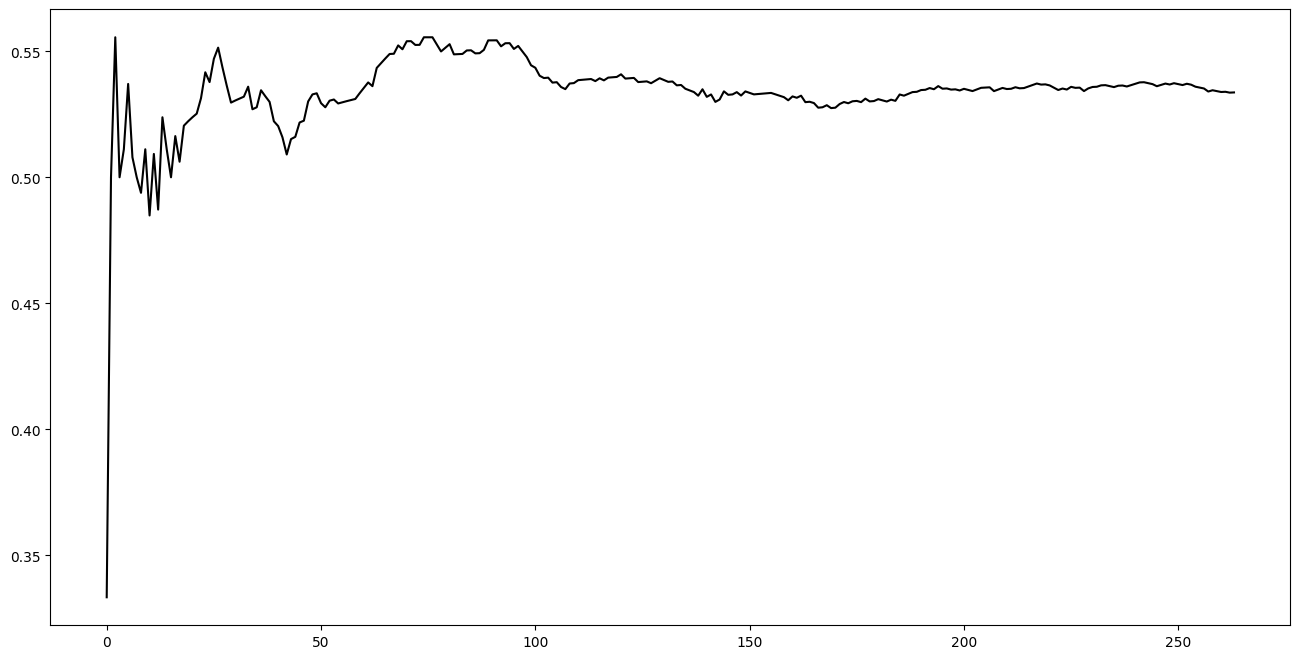

In [25]:
sd_avg_error = 0
sd_avg_direction = 0
counter = 0
list_thing = []
for i in range(len(training_vals)):
    for k in range(0, 12):
        l = create_test_set(i, k)
        sd_avg_error += l[0]
        sd_avg_direction += l[1]
        counter += 1
        list_thing.append(sd_avg_direction / counter)
print(sd_avg_error / counter)
print(sd_avg_direction / counter)
plt.figure(figsize=(16,8))
plt.plot(list_thing, color = 'black', label = 'Test')
plt.show()

In [12]:
def create_test_set2(index, graph = False):
    X_test = []
    Y_test = []
    test = training_vals[index]
    test_scaler = scalers[test]
    for key, df in stock_data_testing.items():
        if(key == test):
            if len(df) >= n_days + m_days:
                for i in range(len(df) - n_days - m_days + 1):
                    X_test.append(df.iloc[i:i+n_days, 1:-1].to_numpy())
                for i in range(len(df) - n_days - m_days + 1):
                    Y_test.append(df.iloc[i+n_days:i+n_days+m_days, -1].to_numpy())

    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    y_pred = model.predict(X_test)
    avg_error = 0
    for i in range(len(Y_test[0])):
        avg_error += abs(Y_test[0][i] - y_pred[0][i])
    
    avg_error =  avg_error / len(Y_test[0]) * 100

    direction_counter = 0
    for i in range(len(Y_test[0])-1):
        if(sgn(y_pred[0][i + 1] - y_pred[0][i]) is sgn(Y_test[0][i + 1] - Y_test[0][i])):
            direction_counter += 1
    direction_counter = abs(direction_counter / (len(Y_test[0]) - 1))
    print(test, direction_counter, avg_error)
    if(graph):
        real_values_test = test_scaler.inverse_transform(Y_test)
        real_values_predict = test_scaler.inverse_transform(y_pred)
        plt.figure(figsize=(16,8))
        a, b = 0,1
        plt.ylim((a, b))
        plt.plot(Y_test[0], color = 'black', label = 'Test')
        plt.plot(y_pred[0], color = 'green', label = 'pred')
        plt.legend()
        plt.show()

        plt.figure(figsize=(16,8))
        plt.plot(real_values_test[0], color = 'black', label = 'Test')
        plt.plot(real_values_predict[0], color = 'green', label = 'pred')
        plt.legend()
        plt.show()
    return avg_error, direction_counter
    

In [13]:
l = create_test_set2(1)
print(l)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
WELL 0.2222222222222222 1.41236453581161
(1.41236453581161, 0.2222222222222222)


In [14]:
sd_avg_error = 0
sd_avg_direction = 0
negated = 0
for i in range(len(training_vals)):
    l = create_test_set2(i)
    sd_avg_error += l[0]
    sd_avg_direction += l[1]
print(sd_avg_error / (len(training_vals) - negated))
print(sd_avg_direction / (len(training_vals) - negated))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
OTIS 0.3333333333333333 1.06971856089644
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
WELL 0.2222222222222222 1.41236453581161
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
SWK 0.4444444444444444 2.740399995061101
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
LYV 0.7777777777777778 1.9074616056552096
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
ED 0.6666666666666666 7.075293190523051
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
COO 0.6666666666666666 1.5000000209563336
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
SBUX 0.4444444444444444 2.36124624677855
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
PM 0.6666666666666666 6.673659668158738
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
TJX 0.6666666666666666 2.8604138882756547
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
DUK 0.7777777777777778 9.385121539243661
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
TRGP 0.6666666666666666 4.414069356249882
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
WYNN 0.5555555555555556 1.3049435784143544
14/14 ━━━━━━━━━━━━━━━━━━━━